<a href="https://colab.research.google.com/github/RayCyder/Intro/blob/main/ResNet_Implementation_on_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#TestConfig
#This file is used to configure the test environment for the project. It contains settings and parameters that are necessary for running tests effectively.
class TestConfig:
    val_epochs = 20
    train_epochs = 100
    batch_size = 128
    train_samples_per_class = 500
    test_samples_per_class = 100
    random_seed = 888
    val_ratio = 0.1
    weight_decay = 0

class StandardConfig:
    val_epochs = 20
    train_epochs = 100
    batch_size = 128
    train_samples_per_class = 5000 #50000
    test_samples_per_class = 1000 #10000
    random_seed = 888
    val_ratio = 0.1
    weight_decay = 0

import torch
# class BaseOptimizer(torch.optim.Optimizer):
#     pass
class OptimizerConfig:
    def get_optimizers():
        #search subclasses of torch.optim.Optimizer
        #all_classes = BaseOptimizer.__subclasses__()
        optimizers = {
        # "Muon-MVR2": MuonMVR2Optimizer,
        "SGD": SGDOptimizer,
        "ADAM": AdamOptimizer,
        "AdaOrthL": AdaOrthLOptimizer,
        "AdaOrthL+": AdaOrthLPLusOptimizer,
        "AdaGradNorm": AdaGradNormOptimizer,
        "STORM+": STORMPlusOptimizer,
        }
        return optimizers
    colors = {
        # "Muon-MVR2": "#d62728",
        "SGD": "#9467bd",
        "ADAM": "#e377c2",
        "AdaOrthL": "#bcbd22",
        "AdaOrthL+": "#1f77b4",
        "AdaGradNorm": "#ff7f0e",
        "STORM+": "#2ca02c",
    }

global_config = TestConfig()

## model from paper
The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

**Defining the Network Architecture**
In this section the entire Research Paper is implemented to define the Residual Network approach taken by the researchers

NOTE:

Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [126]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

## Random Seed

In [127]:
import torch
import random
import numpy as np
random.seed(global_config.random_seed)
torch.manual_seed(global_config.random_seed)
torch.cuda.manual_seed_all(global_config.random_seed)
np.random.seed(global_config.random_seed)

## Train Loop

In [128]:
import time
import torch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import copy
class TrainConfig(object):
  epochs = 100

# choose device
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")
if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# method for initialize model
def initialize_model(device):
    # resnet18 = models.resnet18(weights=None, num_classes=10)   # train from scratch
    resnet18 = ResNet18()
    # resnet18.load_state_dict(torch.load('baseline.pt'))
    resnet18 = resnet18.to(device)
    if device == "cuda" and torch.cuda.device_count() > 1:
        resnet18 = torch.nn.DataParallel(resnet18)
    return resnet18

base_model = initialize_model(device)
base_init_state = copy.deepcopy(base_model.state_dict())
def get_base_model():
    model = initialize_model(device)
    model.load_state_dict(copy.deepcopy(base_init_state))
    return model

Using device: cuda


In [129]:
import time
import torch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# base class for optimizer with scheduler
class BaseOptimizer(object):
  def __init__(self,model, criterion, epochs,learning_rate):
    self.epochs = epochs
    self.criterion = criterion
    self.model = model
    self.optimizer,self.scheduler = None, None
    self.learning_rate = learning_rate
  def initialize_optimzer(self):
    raise Exception("non implemetation")
  def zero_grad(self,inputs=None,labels=None):
    self.optimizer.zero_grad()
  def step(self):
    self.optimizer.step()
  def epoch_step(self):
    if self.scheduler:
      self.scheduler.step()
  
  def set_scheduler(self, optimizer, learning_rate, rate=0.1):
     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=rate*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
     self.scheduler = scheduler
     return scheduler

class TrainModel(object):
  def __init__(self,train_loader=None, val_loader=None, classes=None,epochs=100):
    self.criterion = torch.nn.CrossEntropyLoss()
    self.val_loader = val_loader
    self.train_loader = train_loader
    self.classes = classes
    self.epochs = epochs
  def initialize_model(self):
    model = get_base_model()
    self.model = model
    return model
  def train(self, optimizer, need_save=False):
    epochs = self.epochs
    model, criterion = self.model, self.criterion
    train_loader, val_loader, classes = self.train_loader, self.val_loader, self.classes
    #start train
    losses = [] #train loss
    val_losses = [] #val loss
    accs =[] #train accuracy
    elapsed_all = [] #time cost
    val_accs = [] #val accurary
    best = 0.0 #best accuraray
    #optimizer = MuonMVR2Optimizer(model,criterion,epochs,learning_rate)
    #optimizer.initialize_optimizer()
    start = time.time()
    for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad(inputs, labels)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss+=loss.item()
          correct += (outputs.argmax(dim=1) == labels).sum().item()
      accuracy = 100. * correct / len(train_loader.dataset)
      accs.append(accuracy)
      # step the scheduler once per epoch
      optimizer.epoch_step()
      losses.append(running_loss/max(1, len(train_loader)))
      if optimizer.scheduler:
        current_lr = optimizer.scheduler.get_last_lr()[0]  # single param group
      else:
        current_lr = optimizer.learning_rate
      #val_loss = val_once(model,criterion,val_loader)
      val_loss, val_acc = test_model(model, criterion, val_loader, classes)
      if val_acc > best:
        if need_save:
          state = {'model': model.state_dict(),
                  'accuracy': val_acc,
                  'epoch': epoch,}
          if not os.path.isdir('checkpoints'):
              os.mkdir('checkpoints')
          def _get_name(opt):
            return opt.__name__ if hasattr(opt, "__name__") else opt.__class__.__name__
          torch.save(state, f'checkpoints/best_model_{_get_name(optimizer)}.pth')
        best = val_acc

      val_losses.append(val_loss)
      val_accs.append(val_acc)
      elapsed = time.time() - start
      elapsed_all.append(elapsed)
      print(f"[{epoch+1}] time: {elapsed} loss: {losses[-1]:.3f} val_loss:{val_loss} current_lr={current_lr:.6f}")

    print(f"Training finished!")
    return losses, accs, val_losses, val_accs, elapsed_all

@torch.no_grad()
def test_model(ResNet18, criterion, test_loader, classes):
  test_loss = 0.0
  class_correct = [0 for _ in range(10)]
  class_total   = [0 for _ in range(10)]

  ResNet18.eval()
  # iterate over test data
  for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    count = data.size(0)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target)
    # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(count):
      label = target.data[i]
      class_correct[label] += int(correct_tensor[i].item())
      class_total[label] += 1

  # average test loss
  total_samples = sum(class_total)
  test_loss = test_loss/max(1,  len(test_loader))
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
      acc_i = 100 * class_correct[i] / class_total[i]
      print('Test Accuracy of %5s: %2d%% (%d/%d)' % (
          classes[i],acc_i ,
          class_correct[i], class_total[i]))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
  acc = 100. * np.sum(class_correct) / total_samples
  print('\nTest Accuracy (Overall): %2d%% (%d/%d)' % (
      acc,
      sum(class_correct), total_samples))
  return test_loss, acc

## **CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

### Download And Augmentation
#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**

#**download dataset to local data directory**
#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)


we split train data to two part one is about 0.1 part of train data used as val data ,the last 0.9 part is used as train data

test data only used once to check model at last

so we choose 1000 for each class from 50,000 train data set  and split it to train data(0.9) and val data(0.1)
choose 100 for each class from 10,000 test data as test data;

we use val data to choose best learning rate,and use test data for accuracy and loss validation to avoid data leaking caused  validation loss overfit(val loss become much higher than lowest val loss at the end of training and training loss is very low)

In [130]:
import torchvision, torch
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()   # 只先转成 [0,1] tensor，不做 Normalize
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
loader = DataLoader(trainset, batch_size=100, shuffle=False, num_workers=4)

mean = 0.0
var = 0.0
total = 0

for imgs, _ in loader:
    # imgs shape: [B, 3, 32, 32], 值在 [0,1]
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, 3, -1)  # [B, 3, 32*32]
    mean += imgs.mean(dim=(0, 2)) * batch_samples
    var  += imgs.var(dim=(0, 2), unbiased=False) * batch_samples
    total += batch_samples

mean /= total
var  /= total
std = var.sqrt()

print(mean, std)


Files already downloaded and verified


/home/user/anaconda3/envs/312/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


tensor([0.4914, 0.4822, 0.4465]) tensor([0.2467, 0.2432, 0.2611])


In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split, DataLoader
def sub_dataset(trainset, each_class_len,need_random=False):
  subset_indices = []
  targets = np.array(trainset.targets)
  for c in np.unique(targets):
    class_idx = np.where(targets == c)[0]
    # print(class_idx.shape,class_idx[:10])
    if need_random:
      np.random.shuffle(class_idx)
    subset_indices.extend(class_idx[:each_class_len])
  # Convert subset_indices to a numpy array to allow advanced indexing
  subset_indices = np.array(subset_indices)
  return subset_indices

def sub_sub_indices(subset_indices, val_ratio=0.1,need_random=True):
  # train_set,val_set = random_split(train_subset,[n_train,n_val])
  train_indices = []
  val_indices = []
  val_ratio = 0.1
  subset_labels = targets[subset_indices]
  for c in np.unique(subset_labels):
    class_idx = np.where(subset_labels == c)[0]
    if need_random:
      np.random.shuffle(class_idx)
    n_val = int(len(class_idx)*val_ratio)
    val_indices.extend(subset_indices[class_idx[:n_val]])
    train_indices.extend(subset_indices[class_idx[n_val:]])
  return train_indices, val_indices

transform = transforms.Compose([
    #transforms.Resize(40),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2467, 0.2432, 0.2611))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2467, 0.2432, 0.2611))
])
batch_size = global_config.batch_size
# --- Load full CIFAR-10 train set ---
trainset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
targets = np.array(trainset_full.targets)
# --- Class names ---
classes = trainset_full.classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

# --- (Optional) use only a subset for speed
subset_indices = sub_dataset(trainset_full, global_config.train_samples_per_class, need_random=False)
#train_subset = Subset(trainset_full, subset_indices)

# --- Split subset_indices into train/validation ---
train_indices, val_indices = sub_sub_indices(subset_indices, val_ratio=global_config.val_ratio, need_random=False)
train_set = Subset(trainset_full,train_indices)
val_set  = Subset(trainset_full, val_indices)
train_labels = [classes[x] for x in targets[train_indices]]
val_labels = [classes[x] for x in targets[val_indices]]
# use all
# train_set = trainset_full
# train_labels = [classes[x] for x in targets]
# --- DataLoaders ---
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle=False,num_workers=4)
# --- Test Set ---
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=4)
test_targets = np.array(test_set.targets)
test_labels = [classes[x] for x in test_targets]
# use part of test
test_indices = sub_dataset(test_set, global_config.test_samples_per_class, need_random=False)
test_set_sub =  Subset(test_set, test_indices)
test_labels = [classes[x] for x in test_targets[test_indices]]
test_loader =  DataLoader(test_set_sub,batch_size = batch_size, shuffle=False)
#use test set as val set if val set is empty
# that is, if val_ratio is 0, then val set is empty, we use test set as val set
if len(val_set) == 0:
  val_set = test_set
  val_loader = test_loader
  val_labels = test_labels

print(f"Batch size:{batch_size}, \
      Train batches:{len(train_loader)}, \
      Val batches:{len(val_loader)},\
      Test batches:{len(test_loader)}")
# check train and val set is balanced or not
from collections import Counter
print("Train class counts:",Counter(train_labels))
print("Val class counts:", Counter(val_labels))
print("Test class counts:", Counter(test_labels))

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified
Batch size:128,       Train batches:71,       Val batches:8,      Test batches:40
Train class counts: Counter({'airplane': 900, 'automobile': 900, 'bird': 900, 'cat': 900, 'deer': 900, 'dog': 900, 'frog': 900, 'horse': 900, 'ship': 900, 'truck': 900})
Val class counts: Counter({'airplane': 100, 'automobile': 100, 'bird': 100, 'cat': 100, 'deer': 100, 'dog': 100, 'frog': 100, 'horse': 100, 'ship': 100, 'truck': 100})
Test class counts: Counter({'airplane': 500, 'automobile': 500, 'bird': 500, 'cat': 500, 'deer': 500, 'dog': 500, 'frog': 500, 'horse': 500, 'ship': 500, 'truck': 500})


### **Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.5403687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.3638976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.2670603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.3241572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.5645559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.5645559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

(3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.5645559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.0062352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.5645559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0905959..1.5484309].


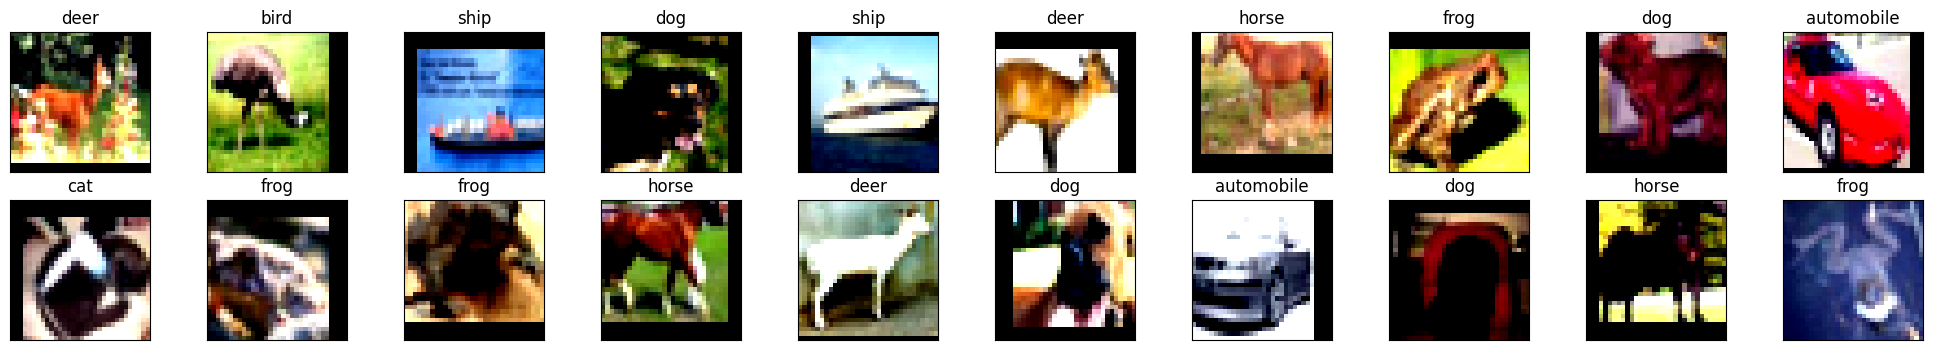

In [132]:
import matplotlib.pyplot as plt
import numpy as np
print(classes)
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print(images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## AdaOrth Optimizer
**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf)
Adam
MuonMVR2
AdaOrth
 as Optimizer with momentum and weight decay specified by the research paper of **ON THE CONVERGENCE OF MUON AND BEYOND**

#**AdaOrthL method:** 


![alt text](https://github.com/RayCyder/Intro/blob/main/adaorth.jpg?raw=1)

#**AdaOrthL+ method:** similar like MuonMVR2 use two random batches to decrease noise

![alt text](https://github.com/RayCyder/Intro/blob/main/adaorth+.jpeg?raw=1)


In [133]:
import torch

# ---------- compile helper (MPS uses aot_eager; CUDA/CPU uses inductor) ----------
def _compile_for_device(fn):
    if torch.backends.mps.is_available():
        return torch.compile(fn, backend="aot_eager", dynamic=True)
    return torch.compile(fn, backend="inductor", dynamic=True)


@_compile_for_device
def zeropower_via_newtonschulz5(
    G: torch.Tensor,
    steps: int = 3,
    eps: float = 1e-7,
) -> torch.Tensor:
    """
    Approximate Orth(G) via a Newton–Schulz-style iteration (polar-factor-like).

    - Uses bf16 for matmul speed; returns to original dtype.
    - Normalizes by Frobenius norm as a cheap stabilizer (keeps scale small).
    - If m>n, works on G^T to reduce cost of A = X X^T.
    """
    assert G.ndim == 2
    a, b, c = 3.4445, -4.7750, 2.0315

    out_dtype = G.dtype
    bf16 = torch.bfloat16

    # Work in bf16 for speed; keep on same device.
    X = G.to(dtype=bf16)

    # Stabilize scaling: avoid division by zero and keep values bounded.
    # (Frobenius norm is cheap; if you prefer spectral norm, it's too expensive.)
    X = X / (X.norm() + eps)

    m, n = X.shape
    transposed = m > n
    if transposed:
        X = X.transpose(0, 1)  # .T is fine too; transpose is explicit

    # Newton–Schulz iterations
    for _ in range(steps):
        A = X @ X.transpose(0, 1)      # A = X X^T
        A2 = A @ A                    # reuse A^2
        B = b * A + c * A2
        X = a * X + (B @ X)

    if transposed:
        X = X.transpose(0, 1)

    return X.to(dtype=out_dtype)


# =========================
# Base optimizer
# =========================
class AdaOrthBasic(torch.optim.Optimizer):
    """
    Base class:
      - 2D params (matrices): delegate to step_detail(...) implemented by subclasses
      - non-2D params: use a simple AdamW-like update with a corrected input c_t
    """

    def __init__(
        self,
        params,
        lr: float = 1e-3,
        weight_decay: float = 0.0,
        adamw_betas=(0.95, 0.99),
        gamma: float = 0.025,
        eps: float = 1e-8,
    ):
        defaults = dict(lr=lr, weight_decay=weight_decay, adamw_betas=adamw_betas, gamma=gamma, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def update_last_grad(self):
        """Cache current p.grad into state['last_grad'] for all params."""
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                state = self.state[p]
                if "last_grad" not in state:
                    state["last_grad"] = torch.zeros_like(p)
                state["last_grad"].copy_(p.grad)

    # ---- hooks for subclasses ----
    def step_detail(self, grad: torch.Tensor, state: dict, *, eps: float, lr: float) -> tuple[torch.Tensor, torch.Tensor]:
        """Return (eta_t, update_matrix) for 2D parameters. Must be overridden."""
        raise NotImplementedError

    # ---- internal helpers ----
    @staticmethod
    def _init_scalar_state_like(p: torch.Tensor, grad: torch.Tensor, value: float) -> torch.Tensor:
        """Create a 0-dim tensor on the same device/dtype as grad."""
        return torch.tensor(value, device=p.device, dtype=grad.dtype)

    @torch.no_grad()
    def _init_state(self, p: torch.Tensor, grad: torch.Tensor):
        state = self.state[p]
        if len(state) != 0:
            return

        state["step"] = 0
        state["last_grad"] = torch.zeros_like(p)

        if p.ndim == 2:
            # 2D (matrix) states (subclasses may use a subset, but it's fine to pre-create)
            state["m_t"] = torch.zeros_like(p)

            # scalar accumulators as 0-dim tensors (device-safe)
            state["g_sum"] = self._init_scalar_state_like(p, grad, 0.0)   # Σ g_i^2
            state["g_max"] = self._init_scalar_state_like(p, grad, 0.0)   # max g_i^2

            # common accumulator for Σ ||M_i||^2 / α_i
            state["H_sum"] = self._init_scalar_state_like(p, grad, 0.0)

            # for AdaOrth-L+ prefix-min alpha
            state["alpha"] = self._init_scalar_state_like(p, grad, 1.0)   # alpha_0 = 1
        else:
            # non-2D: AdamW-like moments
            state["exp_avg"] = torch.zeros_like(p)
            state["exp_avg_sq"] = torch.zeros_like(p)

    @torch.no_grad()
    def _step_non2d(self, p: torch.Tensor, grad: torch.Tensor, state: dict, *, lr: float, eps: float,
                    weight_decay: float, beta1: float, beta2: float, gamma: float):
        """Non-2D parameters: corrected-input AdamW-like update (engineering choice)."""
        step = state["step"]
        last_grad = state["last_grad"]

        # c_t = g_t + gamma * (beta1/(1-beta1)) * (g_t - g_{t-1})
        c_t = (grad - last_grad).mul(gamma * (beta1 / (1.0 - beta1))).add(grad)

        # unit-norm clipping to avoid rare spikes
        c_norm = torch.norm(c_t)
        if c_norm > 1.0:
            c_t = c_t / c_norm

        exp_avg = state["exp_avg"]
        exp_avg_sq = state["exp_avg_sq"]

        # EMA updates
        exp_avg.lerp_(c_t, 1.0 - beta1)               # m_t
        exp_avg_sq.lerp_(c_t.square(), 1.0 - beta2)   # v_t


        g_hat = exp_avg / (eps + exp_avg_sq.sqrt())

        # bias correction
        bias_correction1 = 1.0 - beta1 ** step
        bias_correction2 = 1.0 - beta2 ** step
        scale = bias_correction1 / (bias_correction2 ** 0.5)

        # decoupled weight decay + update
        p.data.mul_(1.0 - lr * weight_decay)
        p.data.add_(g_hat, alpha=-lr / scale)

    @torch.no_grad()
    def step(self):
        """
        One optimizer step. n.   

        For 2D params: delegates to step_detail(...) implemented in subclasses (AdaOrth-L / AdaOrth-L+).
        For non-2D params: uses a simple AdamW-like rule with corrected input c_t.

        IMPORTANT (AdaOrth-L+):
          state["last_grad"] must store ∇f(X_{t-1}; ξ_t) computed on the SAME ξ_t as current grad ∇f(X_t; ξ_t).
          This must be ensured by the training loop via update_last_grad().
        """
        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["adamw_betas"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]
            gamma = group["gamma"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad
                self._init_state(p, grad)

                state = self.state[p]
                state["step"] += 1

                if p.ndim == 2:
                    eta_t, update = self.step_detail(grad, state, eps=eps, lr=lr)
                    # engineering choice: keep decoupled weight decay for matrices as well
                    p.data.mul_(1.0 - lr * weight_decay)
                    p.data.add_(update, alpha=-eta_t)
                else:
                    self._step_non2d(
                        p, grad, state,
                        lr=lr, eps=eps, weight_decay=weight_decay,
                        beta1=beta1, beta2=beta2, gamma=gamma
                    )


# =========================
# AdaOrth-L (Algorithm 1)
# =========================
class AdaOrthL(AdaOrthBasic):
    @torch.no_grad()
    def step_detail(self, grad: torch.Tensor, state: dict, *, eps: float, lr: float):
        # Paper mapping:
        #   G_t=grad,  g_t^2=||G_t||_F^2,  α_t=(1+Σ g_i^2)^(-1/2),
        #   M_t=(1-α_t)M_{t-1}+α_t G_t,
        #   H_t=Σ ||M_i||^2/α_i,
        #   γ_t=min( α_t/(eps+max g^2), (eps+H_t)^(-1/2) ),
        #   η_t=θ γ_t ||M_t||_F (θ=lr),
        #   update=Orth(M_t)
        g_sq = grad.norm().pow(2)
        state["g_sum"] = state["g_sum"] + g_sq
        state["g_max"] = torch.maximum(state["g_max"], g_sq)

        alpha = (1.0 + state["g_sum"]).pow(-0.5)

        M = state["m_t"]
        M.mul_(1.0 - alpha).add_(grad, alpha=alpha)
        m_norm = M.norm()

        H = state["H_sum"] + (m_norm.pow(2) / (alpha + eps))
        state["H_sum"] = H

        gamma1 = alpha / (eps + state["g_max"])
        gamma2 = (eps + H).pow(-0.5)
        gamma_t = torch.minimum(gamma1, gamma2)

        eta_t = lr * gamma_t * m_norm
        update = zeropower_via_newtonschulz5(M)
        return eta_t, update


# =========================
# AdaOrth-L+ (Algorithm 2)
# =========================
class AdaOrthLPlus(AdaOrthBasic):
    @torch.no_grad()
    def step_detail(self, grad: torch.Tensor, state: dict, *, eps: float, lr: float):
        # Paper mapping:
        #   G_t=grad,  G_{t-1}(same ξ_t)=state["last_grad"],
        #   α_t = min_{k<=t} ((eps+max g_i^2)/(eps+Σ g_i^2))^(2/3) (prefix-min recursion),
        #   M_t=(1-α_t)(M_{t-1}-G_{t-1})+G_t,
        #   H_t=Σ ||M_i||^2/α_i,
        #   γ_t=min( sqrt(α_t)/(eps+max g^2), (eps+H_t)^(-1/2) ),
        #   η_t=θ γ_t ||M_t||_F (θ=lr),
        #   update=Orth(M_t)
        g_sq = grad.norm().pow(2)
        state["g_sum"] = state["g_sum"] + g_sq
        state["g_max"] = torch.maximum(state["g_max"], g_sq)

        r_t = ((eps + state["g_max"]) / (eps + state["g_sum"])).pow(2.0 / 3.0)
        alpha = torch.minimum(state["alpha"], r_t)   # prefix-min
        state["alpha"] = alpha

        M = state["m_t"]
        M.sub_(state["last_grad"]).mul_(1.0 - alpha).add_(grad)
        m_norm = M.norm()

        H = state["H_sum"] + (m_norm.pow(2) / (alpha + eps))
        state["H_sum"] = H

        gamma1 = alpha.sqrt() / (eps + state["g_max"])
        gamma2 = (eps + H).pow(-0.5)
        gamma_t = torch.minimum(gamma1, gamma2)

        eta_t = lr * gamma_t * m_norm
        update = zeropower_via_newtonschulz5(M)
        return eta_t, update

## AdaGrad-Norm Optimizer


![alt text](https://github.com/RayCyder/Intro/blob/main/AdaGrad-Norm.jpg?raw=1)


In [134]:
import torch

class AdaGradNorm(torch.optim.Optimizer):
    """
    AdaGrad-Norm (Ward et al.): 
        b_{t+1}^2 = b_t^2 + ||g_t||^2
        x_{t+1} = x_t - (eta / b_{t+1}) * g_t
    """

    def __init__(self, params, lr=1.0, b0=1.0, eps=1e-8, weight_decay=0.0):
        if b0 <= 0:
            raise ValueError("b0 must be > 0")
        defaults = dict(lr=lr, b0=b0, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            lr = group["lr"]          # eta
            eps = group["eps"]
            weight_decay = group["weight_decay"]
            b0 = group["b0"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]
                g2 = grad.norm().pow(2)
                # init b2 = b0^2
                if "b2" not in state:
                    state["b2"] = torch.tensor(b0 * b0, device=g2.device, dtype=g2.dtype)
                b2 = g2 + state['b2']
                state['b2'] = b2
                denom = b2.sqrt().add(eps)   # b_{t+1} + eps
                eta = lr / (denom + eps)
                p.data.mul_(1.0 - lr * weight_decay)
                p.data.add_(grad, alpha=-eta)

        return loss

## STORM Optimizer


![alt text](https://github.com/RayCyder/Intro/blob/main/storm+.jpg?raw=1)


In [135]:
import torch

class STORMPlus(torch.optim.Optimizer):
    """
    STORM+ optimizer (AdaOrth-style usage with update_last_grad).

    REQUIREMENT (strict STORM correction):
      state[p]["last_grad"] must store ∇f(x_{t-1}; ξ_t) for the SAME mini-batch ξ_t
      used to compute current grad ∇f(x_t; ξ_t) before calling step().

    Core recursion (per step):
      d_t = g_t + (1 - a_t) (d_{t-1} - last_grad)
      x_{t+1} = x_t - eta_t * d_t

    where a_t, eta_t are global adaptive scalars (per param_group):
      a_t   = (1 + Σ ||g||^2)^(-2/3)
      eta_t = (eps + Σ (||d||^2 / a_t))^(-1/3)
    """

    def __init__(self, params, lr=1.0, eps=1e-8, weight_decay=0.0):
        defaults = dict(lr=lr, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def update_last_grad(self):
        """
        Cache current gradients into state[p]["last_grad"].

        You should call this right after computing grad at OLD parameters x_{t-1}
        on the SAME batch ξ_t that will later be used at x_t.
        """
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                st = self.state[p]
                if "last_grad" not in st:
                    st["last_grad"] = torch.zeros_like(p)
                st["last_grad"].copy_(p.grad)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]
            params = group["params"]

            # init per-parameter state
            for p in params:
                if p.grad is None:
                    continue
                state = self.state[p]
                g_t = p.grad
                #comput d_t use last grad and a_t-1
                # d_t = g_t + (1-a_t)(d_{t-1} - last_grad)
                if 'a_t' not in state: #first
                    d_t = p.grad
                else:
                    #a_t actually is a_t-1
                    d_t = g_t + (1.0 - state['a_t']) * (state['d'] - state['last_grad'])
                state['d'] = d_t
                # compute ||g_t||^2
                g2 = g_t.norm().pow(2)
                # lazy init group scalars on correct device/dtype
                if state.get("g2_sum") is None:
                    state["g2_sum"] = torch.zeros_like(g2)
                if state.get("d2_over_a_sum") is None:
                    state["d2_over_a_sum"] = torch.zeros_like(g2)
                # a_t = (1 + Σ ||g||^2)^(-2/3)
                state["g2_sum"] = state["g2_sum"] + g2
                a_t = (1.0 + state["g2_sum"]).pow(-2.0 / 3.0)
                state['a_t'] = a_t #save for next step
                #d2 = Σ (||d_t||^2 / a_t)
                d2_over_a = state['d'].norm().pow(2) / a_t
                state["d2_over_a_sum"] = state["d2_over_a_sum"] + d2_over_a
                # eta_t = (eps + Σ (||d_t||^2 / a_t))^(-1/3)
                eta_t  = (state["d2_over_a_sum"] + eps).pow(-1.0 / 3.0)
                # parameter update: x <- x - lr*eta_t*d_t  (lr is treated as θ-like multiplier)
                step_size = lr * eta_t
                # (optional) decoupled weight decay
                p.data.mul_(1.0 - step_size * weight_decay)
                p.data.add_(d_t, alpha=-step_size)


        return loss

## Muon-MVR2 Optimzier
**Muon-MVR2 method from ON THE CONVERGENCE OF MUON AND BEYOND**

fixed some error for mac M1

mvr2 only works with 2 dim weights, other dims use method like adam

In [136]:
'''
Muon-MVR For LLM Pretraining.
'''
import torch
import math

#fix for mps
def _compile_for_device(fn):
    # Inductor doesn't support MPS; use AOTAutograd there.
    if torch.backends.mps.is_available():
        return torch.compile(fn, backend="aot_eager", dynamic=True)
    # Inductor is fine on CUDA/CPU
    return torch.compile(fn, backend="inductor", dynamic=True)


@_compile_for_device
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    d_type = G.dtype
    X = G.bfloat16()
    #x_flat = X.reshape(-1)      # 把矩阵展平成一个 1D 向量
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(d_type)

class MuonMVR(torch.optim.Optimizer):
    r'''
    Standard MVR:\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t})
    Approximate MVR:
        1.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t-1})
        2.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t};\xi_{t-1}), It has low computational complexity
         and is more convenient in practice
    '''
    def __init__(self, params, lr=3e-3, momentum = 0.95 ,adamw_betas=(0.95, 0.99), eps=1e-8,
                 weight_decay=0.0, gamma=0.025, is_approx=False):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum parameter: {momentum}")
        if not 0.0 <= adamw_betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {adamw_betas[0]}")
        if not 0.0 <= adamw_betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {adamw_betas[1]}")

        defaults = dict(lr=lr, momentum=momentum,adamw_betas=adamw_betas, eps=eps,
                       weight_decay=weight_decay, gamma=gamma)
        super().__init__(params, defaults)
        self.is_approx = is_approx

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        # adjusted_ratio = math.sqrt(A*B)
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    @torch.no_grad()
    def update_last_grad(self):
        if not self.is_approx:
            for group in self.param_groups:
                for p in group['params']:
                    state = self.state[p]
                    if "last_grad" not in state:
                        state["last_grad"] = torch.zeros_like(p)
                    state["last_grad"].zero_().add_(p.grad, alpha=1.0)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['adamw_betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            gamma = group['gamma']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['last_grad'] = torch.zeros_like(p)
                    # state['previous_grad'] = torch.zeros_like(p)
                    if len(p.shape) != 2:  # Only for 2D tensors
                        state['exp_avg_sq'] = torch.zeros_like(p)

                state['step'] += 1
                last_grad = state['last_grad']
                if len(p.shape) == 2:
                    exp_avg = state['exp_avg']

                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (momentum / (1. - momentum))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    # Update moving averages
                    exp_avg.mul_(momentum).add_(c_t, alpha=1 - momentum)
                    update = zeropower_via_newtonschulz5(exp_avg.mul(1./(1.- momentum))) # whiten the update
                    adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(update, alpha=-adjusted_lr)
                else:
                    # For bias vectors - use simple update
                    step = state['step']
                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (beta1 / (1. - beta1))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    # avoid inductor lowering bug: compute norm explicitly and detach
                    # c_t_norm = torch.sqrt(torch.sum((c_t.detach() * c_t.detach()), dim=None))
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    exp_avg.lerp_(c_t, 1 - beta1)
                    exp_avg_sq.lerp_(c_t.square(), 1 - beta2)
                    g = exp_avg / (eps + exp_avg_sq.sqrt())
                    bias_correction1 = 1 - beta1**step
                    bias_correction2 = 1 - beta2**step
                    scale = bias_correction1 / bias_correction2**0.5
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(g, alpha=-lr / scale)

                if self.is_approx:
                    state['last_grad'].copy_(grad)

#**MuonMVR Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

### MVR2 Usage
3.  **Optimizer Modes**
    MuonMVR can be initialized in different modes to trade off between precision and computational cost.

    **Exact Variance Reduction (`is_approx=False`)**
    To achieve the most precise variance reduction, you must manually manage the model state. Before calculating the gradient for the previous batch, you need to load the model state from the previous iteration. This ensures that the gradient is computed with the correct model weights.
    ```python
    optimizer = MuonMVR(model.parameters(), lr=1e-3, is_approx=False)
    old_state_dict = {}
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Store the current model state
        cur_state_dict = {k: v.data.clone() for k, v in net.state_dict().items()}
    
        if old_state_dict:
            # Load the previous model state to compute the old gradient
            net.load_state_dict(old_state_dict)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.update_last_grad()
    
        # Restore the current model state to compute the new gradient
        net.load_state_dict(cur_state_dict)
        old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
        
        # Standard forward/backward pass and step
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    ```

## Optimizer with Scheduler

In [137]:
class TwoStepOptimizer(BaseOptimizer):
  def __init__(self,model,criterion, epochs, learning_rate):
    super().__init__(model,criterion, epochs, learning_rate)
    self.old_state_dict = {}
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = self.get_optimizer()
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler
    

  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()

  def get_optimizer(self):
    raise NotImplementedError
  
class OneStepOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs,learning_rate):
    super().__init__(model,criterion,epochs, learning_rate)
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = self.get_optimizer()
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

  def get_optimizer(self):
    raise NotImplementedError

class AdaGradNormOptimizer(OneStepOptimizer):
  def get_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = AdaGradNorm(self.model.parameters(), lr=learning_rate, b0=1.0, eps=1e-8, weight_decay=global_config.weight_decay)
    return optimizer
class STORMPlusOptimizer(TwoStepOptimizer):
  def get_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = STORMPlus(self.model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=global_config.weight_decay)
    return optimizer

In [138]:
class MuonMVR2Optimizer(BaseOptimizer):
  def __init__(self,model,criterion, epochs, learning_rate):
    super().__init__(model,criterion, epochs, learning_rate)
    self.old_state_dict = {}
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = MuonMVR(self.model.parameters(), lr=learning_rate,weight_decay=global_config.weight_decay,gamma=0.1,is_approx=False)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()


class SGDOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs,learning_rate):
    super().__init__(model,criterion,epochs, learning_rate)
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=global_config.weight_decay,momentum=0.9)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler


class AdamOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs,learning_rate):
    super().__init__(model,criterion,epochs, learning_rate)
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=global_config.weight_decay)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler


class AdaOrthLOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs,learning_rate):
    super().__init__(model,criterion,epochs, learning_rate)
    self.old_state_dict = {}
  def initialize_optimizer(self):
    learning_rate = self.learning_rate
    optimizer = AdaOrthL(self.model.parameters(), lr=learning_rate, weight_decay=global_config.weight_decay, gamma=0.1)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler
  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if self.old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()


class AdaOrthLPLusOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs,learning_rate):
    super().__init__(model,criterion,epochs, learning_rate)
  def initialize_optimizer(self):
    #weight_decay=0.01,gamma=0.1
    learning_rate = self.learning_rate
    optimizer = AdaOrthLPlus(self.model.parameters(), lr=learning_rate, weight_decay=global_config.weight_decay,gamma=0.1)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler


    

## **grid search learning rate**

In [139]:
# learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
# def grids_search_val(get_optimizer):
#   result = []
#   for ii, learning_rate in enumerate(learning_rates):
#     print(f".........Learning rate {ii+1}/{len(learning_rates)}: {learning_rate}............")
#     model = initialize_model(device)
#     optimizer = get_optimizer(model, learning_rate)
#     train_losses, train_accs, val_losses, val_accs, time_cost = train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs)
#     result.append(min(val_losses))
#   return result

# import copy
# import numpy as np
import copy
def grid_search_val_no_earlystop(optimizer_class, learning_rates, train_object_val):
    # 固定初始模型权重，保证不同lr可比（不动seed也行）
    all_results = {
        "best_val_loss": [],# 每个lr的 final val loss
        "best_train_loss": [],
        "best_val_acc": [],
        "best_train_acc": [],
        "time_cost": []
    }
    for ii, lr in enumerate(learning_rates):
        print(f".........Learning rate {ii+1}/{len(learning_rates)}: {lr}............")
        train_object_val.initialize_model()
        optimizer = optimizer_class(train_object_val.model,train_object_val.criterion,train_object_val.epochs, lr)
        optimizer.initialize_optimizer()
        optimizer.scheduler = None #search using no scheduler
        train_losses, train_accs, val_losses, val_accs, time_cost  = train_object_val.train(optimizer, need_save=False)
        #final_val_loss = float(val_losses[-1])   # ✅ 不用early stop
        best_val_loss = min(val_losses)
        best_train_loss = min(train_losses)
        best_val_acc = max(val_accs)
        best_train_acc = max(train_accs)
        # results.append(best_val_loss)
        all_results["best_val_loss"].append(best_val_loss)
        all_results["best_train_loss"].append(best_train_loss)
        all_results["best_val_acc"].append(best_val_acc)
        all_results["best_train_acc"].append(best_train_acc)
        all_results["time_cost"].append(time_cost)

    best_i = int(np.argmin(all_results["best_val_loss"]))
    best_lr = learning_rates[best_i]
    print(f"\n✅ Best lr by final val loss: {best_lr}, final val loss={all_results['best_val_loss'][best_i]:.6f}")

    return best_lr, all_results



In [140]:
import json
from pathlib import Path
from datetime import datetime

def _to_float_list(xs):
    return [float(x) for x in xs]

def save_grid_result(path: Path, payload: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w") as f:
        json.dump(payload, f, indent=2, sort_keys=True)

def load_grid_result(path: Path):
    with path.open("r") as f:
        return json.load(f)

def grid_cache_path(cache_dir: str, optimizer_name: str, random_seed: int, tag: str = "") -> Path:
    # tag can include model/dataset info, e.g., "resnet18_cifar10"
    tag_part = f"_{tag}" if tag else ""
    return Path(cache_dir) / f"grid_{optimizer_name}{tag_part}_seed{random_seed}.json"

def get_or_run_grid_search(
    optimizer_name: str,
    opt_fn,
    random_seed: int,
    learning_rates,
    train_object: TrainModel,
    epochs: int,
    cache_dir: str = "cache_grid",
    tag: str = "resnet18_cifar10",
    force_rerun: bool = False,
):
    """
    Returns: best_lr (float), all_results (dict)
    Assumes grid_search_val_no_earlystop(opt_fn) returns (best_lr, losses, all_results).
    """
    path = grid_cache_path(cache_dir, optimizer_name, random_seed, tag)

    # metadata to ensure "same run"
    meta = {
        "optimizer": optimizer_name,
        "random_seed": int(random_seed),
        "learning_rates": _to_float_list(learning_rates),
        "epochs": int(epochs),
        "tag": tag,
    }

    if (not force_rerun) and path.exists():
        cached = load_grid_result(path)

        # basic compatibility check
        if cached.get("meta") == meta:
            print(f"[CACHE HIT] {optimizer_name} seed={random_seed} -> {path}")
            return float(cached["best_lr"]) , cached["all_results"]
        else:
            print(f"[CACHE MISMATCH] {optimizer_name} seed={random_seed} -> rerun\n"
                  f"  cached meta: {cached.get('meta')}\n"
                  f"  current meta: {meta}")

    # ---- run grid search ----
    print(f"[CACHE MISS] running grid search for {optimizer_name}, seed={random_seed}")
    # IMPORTANT: you must set seeds BEFORE calling grid_search_val_no_earlystop
    # set_seed(random_seed)  # <- your seed function here

    best_lr, all_results = grid_search_val_no_earlystop(opt_fn,learning_rates,train_object)

    payload = {
        "meta": meta,
        "best_lr": float(best_lr),
        "all_results": all_results,
        "save_at": datetime.now().isoformat(),
    }
    save_grid_result(path, payload)
    print(f"[SAVED] {optimizer_name} seed={random_seed} -> {path}")

    return float(best_lr), all_results

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# optimizers = {
#     # "Muon-MVR2": MuonMVR2Optimizer,
#     "SGD": SGDOptimizer,
#     "ADAM": AdamOptimizer,
#     "AdaOrthL": AdaOrthLOptimizer,
#     "AdaOrthL+": AdaOrthLPLusOptimizer,
#     "AdaGradNorm": AdaGradNormOptimizer,
#     "STORM+": STORMPlusOptimizer,
# }
optimizers = OptimizerConfig.get_optimizers()
# 运行 grid search，保存结果
results = {}
best = {}
train_object_val = TrainModel(train_loader, val_loader, classes, epochs=global_config.val_epochs)#5 for test
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

for name, opt_fn in optimizers.items():
    best_lr, all_results = get_or_run_grid_search(
    optimizer_name=name,
    opt_fn=opt_fn,
    random_seed=global_config.random_seed,
    learning_rates=learning_rates,
    epochs=train_object_val.epochs,
    cache_dir="cache_grid",
    tag="resnet18_cifar10",
    train_object = train_object_val
)
    results[name] = all_results
    best[name] = (best_lr, float(np.min(all_results["best_val_loss"]))) #use val loss to choose best lr
    print(f"[{name}] best lr = {best_lr}, min val loss = {best[name][1]:.6f}")

# 画一张总图
# plt.figure(figsize=(7, 4.5))
# plt.xscale("log")
# plt.xlabel("Learning rate")
# plt.ylabel("Min Validation Loss")
# plt.title("Learning Rate Grid Search (All Optimizers)")
# plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates], rotation=45)

# for name, losses in results.items():
#     plt.plot(learning_rates, losses, marker="o", linewidth=2, label=name)

# plt.legend()
# plt.tight_layout()
# plt.show()

[CACHE HIT] SGD seed=888 -> cache_grid/grid_SGD_resnet18_cifar10_seed888.json
[SGD] best lr = 0.005, min val loss = 0.805806
[CACHE HIT] ADAM seed=888 -> cache_grid/grid_ADAM_resnet18_cifar10_seed888.json
[ADAM] best lr = 0.0001, min val loss = 0.867885
[CACHE HIT] AdaOrthL seed=888 -> cache_grid/grid_AdaOrthL_resnet18_cifar10_seed888.json
[AdaOrthL] best lr = 0.001, min val loss = 0.670866
[CACHE HIT] AdaOrthL+ seed=888 -> cache_grid/grid_AdaOrthL+_resnet18_cifar10_seed888.json
[AdaOrthL+] best lr = 0.0005, min val loss = 0.763400
[CACHE HIT] AdaGradNorm seed=888 -> cache_grid/grid_AdaGradNorm_resnet18_cifar10_seed888.json
[AdaGradNorm] best lr = 0.1, min val loss = 1.824319
[CACHE HIT] STORM+ seed=888 -> cache_grid/grid_STORM+_resnet18_cifar10_seed888.json
[STORM+] best lr = 0.1, min val loss = 1.366289


In [142]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lr_sweep_2x2_by_method(all_result, learning_rates, colors=None,
                                save_path="lr_sweep_2x2.png",
                                x_log=True, sort_by_lr=True):
    """
    all_result: dict(method -> dict(metric -> list over learning_rates))
      required metrics:
        best_train_loss, best_val_loss, best_train_acc, best_val_acc
    learning_rates: list of floats, same length as each metric list
    colors: dict(method -> color) optional
    """
    required_metrics = ["best_train_loss", "best_val_loss", "best_train_acc", "best_val_acc"]

    methods = list(all_result.keys())
    if not methods:
        raise ValueError("all_result is empty.")

    # Validate lengths
    lrs = np.asarray(learning_rates, dtype=float)
    n = len(lrs)

    for m in methods:
        if not isinstance(all_result[m], dict):
            raise TypeError(f"all_result[{m}] must be a dict of metrics.")
        for k in required_metrics:
            if k not in all_result[m]:
                raise KeyError(f"Missing metric '{k}' for method '{m}'.")
            if len(all_result[m][k]) != n:
                raise ValueError(f"Length mismatch: method '{m}' metric '{k}' has {len(all_result[m][k])}, expected {n}.")

    # Sort by lr for nicer curves
    if sort_by_lr:
        order = np.argsort(lrs)
        lrs_sorted = lrs[order]
    else:
        order = None
        lrs_sorted = lrs

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    ax_tl, ax_vl = axes[0, 0], axes[0, 1]
    ax_ta, ax_va = axes[1, 0], axes[1, 1]

    panels = [
        (ax_tl, "best_train_loss", "Base Learning Rate vs Minimum Train Loss", "Min Train Loss"),
        (ax_vl, "best_val_loss",   "Base Learning Rate vs Minimum Test Loss",  "Min Test Loss"),
        (ax_ta, "best_train_acc",  "Base Learning Rate vs Maximum Train Accuracy", "Max Train Accuracy"),
        (ax_va, "best_val_acc",    "Base Learning Rate vs Maximum Test Accuracy",  "Max Test Accuracy"),
    ]

    for ax, metric, title, ylabel in panels:
        for m in methods:
            y = np.asarray(all_result[m][metric], dtype=float)
            if order is not None:
                y = y[order]
            c = colors.get(m, None) if colors else None
            ax.plot(lrs_sorted, y, marker="o", linewidth=2, color=c, label=m)

        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
        if x_log:
            ax.set_xscale("log")

        # legend per subplot (compact)
        ax.legend(loc="best", fontsize=8, frameon=True, ncol=1,
                  borderaxespad=0.25, handlelength=1.8, handletextpad=0.5, labelspacing=0.25)

    for ax in axes[1, :]:
        ax.set_xlabel("Base Learning Rate")

    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)

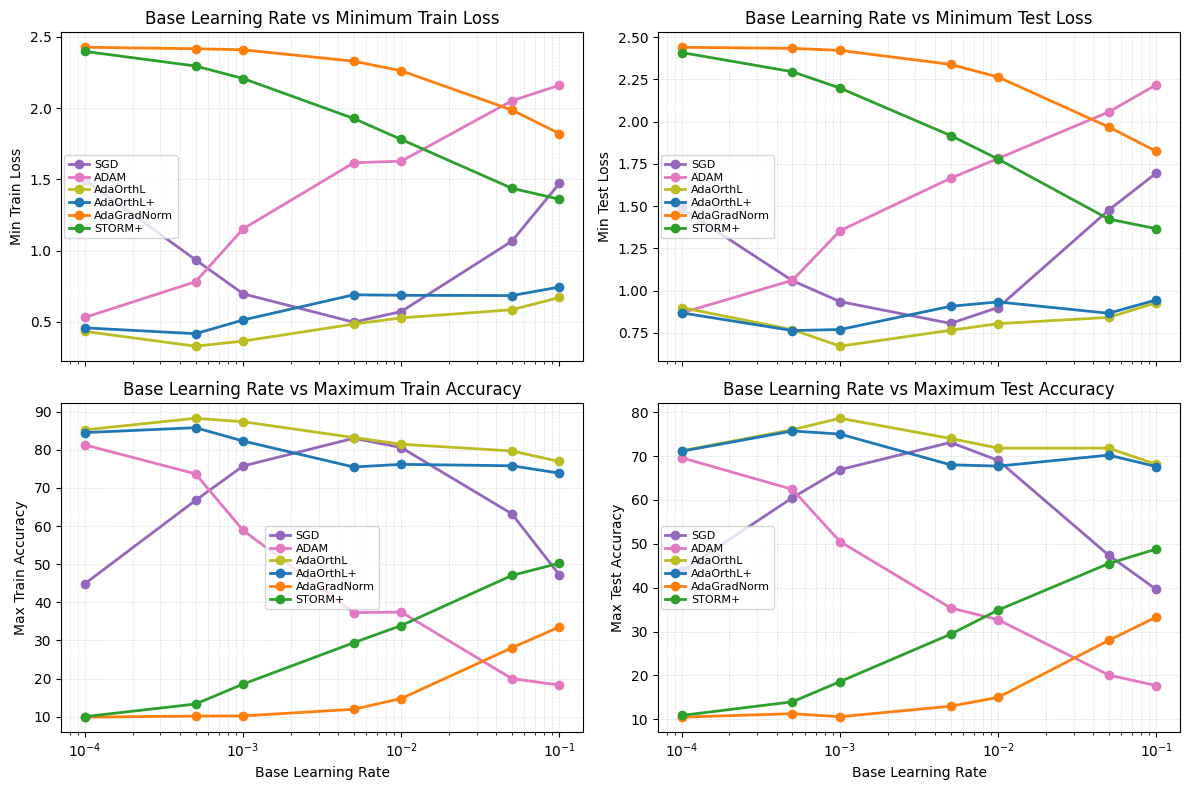

In [143]:
plot_lr_sweep_2x2_by_method(
    all_result=results,
    learning_rates=learning_rates,
    colors=OptimizerConfig.colors,
    save_path="lr_sweep_2x2.png",
    x_log=True
)

## **training Model  using best learning rate**


In [144]:
import json
from pathlib import Path

def to_jsonable(x):
    """Convert common ML objects to JSON-serializable Python types."""
    try:
        import numpy as np
        if isinstance(x, np.ndarray):
            return x.astype(float).tolist()
        if isinstance(x, (np.floating,)):
            return float(x)
        if isinstance(x, (np.integer,)):
            return int(x)
    except Exception:
        pass

    try:
        import torch
        if torch.is_tensor(x):
            x = x.detach().cpu()
            return x.tolist() if x.ndim > 0 else float(x.item())
    except Exception:
        pass

    if isinstance(x, (float, int, str, bool)) or x is None:
        return x
    if isinstance(x, (list, tuple)):
        return [to_jsonable(v) for v in x]
    if isinstance(x, dict):
        return {str(k): to_jsonable(v) for k, v in x.items()}

    # last resort: stringify
    return str(x)

def save_run_results(run_results: dict, filepath: str, meta: dict | None = None):
    payload = {
        "meta": to_jsonable(meta or {}),
        "run_results": to_jsonable(run_results),
        "save_time": datetime.now().isoformat(),
    }
    path = Path(filepath)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, sort_keys=True)
    print(f"[SAVED] {path}")

def load_run_results(filepath: str):
    if os.path.exists(filepath) is False:
        return None, None
    path = Path(filepath)
    with path.open("r", encoding="utf-8") as f:
        payload = json.load(f)
    return payload["run_results"], payload.get("meta", {})



# print(meta2["best_lrs"])

In [ ]:
train_object = TrainModel(train_loader, test_loader, classes, epochs=global_config.train_epochs)#10 for test should be 100
meta = {
    "dataset": "CIFAR10",
    "model": "ResNet18",
    "epochs": train_object.epochs,
    "learning_rates": learning_rates,
    # "best_lrs": {k: v[0] for k, v in best.items()},  # if best[name] = (best_lr, best_loss)
    "random_seed": global_config.random_seed,
}
run_results2, meta2 = load_run_results(f"run_results_seed{global_config.random_seed}.json")
if run_results2 is not None and meta2 == meta:
    print("[LOAD] Loaded existing run results from file.")
    run_results = run_results2
run_results = {}
# for name, (best_lr, _) in best.items():
for name in optimizers.keys():
    best_lr = best[name][0]
    if run_results.get(name) is not None and run_results[name].get("best_lr") == best_lr:
        print(f"[SKIP] {name} already in run_results.")
        continue
    print(f"Training with best lr for {name}: {best_lr}")
    model = train_object.initialize_model()
    optimizer = optimizers[name](model,train_object.criterion,train_object.epochs, best_lr)
    optimizer.initialize_optimizer()
    train_losses, train_accs, test_losses, test_accs, time_costs = train_object.train(optimizer, need_save=True)
    run_results[name] = {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "test_losses": test_losses,
        "test_accs": test_accs,
        "time_curve": time_costs,
        "best_lr": best_lr,
    }
    print(f"{name} Test Accuracy: {test_accs[-1]:.2f}%, Time Cost: {time_costs[-1]:.2f}s")
    save_run_results(run_results, f"run_results_seed{global_config.random_seed}.json", meta=meta)
# optimizer = muonmvr2_optimizer(model_mvr2, learning_rate)
# losses_mvr2, mvr2_acc, losses_mvr2_val, mvr2_acc_val, mvr2_time_cost = train_once(model_mvr2,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)

Training with best lr for SGD: 0.005
Test Loss: 1.807549

Test Accuracy of airplane: 15% (77/500)
Test Accuracy of automobile: 25% (127/500)
Test Accuracy of  bird: 59% (298/500)
Test Accuracy of   cat:  8% (43/500)
Test Accuracy of  deer:  2% (14/500)
Test Accuracy of   dog: 48% (240/500)
Test Accuracy of  frog: 21% (107/500)
Test Accuracy of horse: 61% (307/500)
Test Accuracy of  ship: 29% (146/500)
Test Accuracy of truck: 58% (293/500)

Test Accuracy (Overall): 33% (1652/5000)
[1] time: 7.383589267730713 loss: 1.895 val_loss:1.8075485348701477 current_lr=0.004890
Test Loss: 1.543097

Test Accuracy of airplane:  9% (45/500)
Test Accuracy of automobile: 39% (199/500)
Test Accuracy of  bird: 27% (136/500)
Test Accuracy of   cat: 41% (207/500)
Test Accuracy of  deer: 11% (55/500)
Test Accuracy of   dog:  4% (21/500)
Test Accuracy of  frog: 80% (401/500)
Test Accuracy of horse: 58% (294/500)
Test Accuracy of  ship: 89% (447/500)
Test Accuracy of truck: 64% (323/500)

Test Accuracy (Overa

#**Plot Training Loss and Val Loss**

In [ ]:
# optimizers = {
#     "Muon-MVR2": MuonMVR2Optimizer,
#     "SGD": SGDOptimizer,
#     "Adam": AdamOptimizer,
#     "AdaOrth": AdaOrthOptimizer,
#     "AdaOrthLMinus": AdaOrthLMinusOptimizer,
# }

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

def plot_metrics_2x2(run_results, epochs, colors, save_path="metrics.png",
                     x_log=False, y_log_loss=False, y_log_acc=False,
                     figsize=(12, 8), lw=2):
    epochs_range = list(range(1, epochs + 1))

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=False)
    ax_tr_loss, ax_te_loss = axes[0, 0], axes[0, 1]
    ax_tr_acc,  ax_te_acc  = axes[1, 0], axes[1, 1]

    # ---- plot curves ----
    for name, res in run_results.items():
        c = colors.get(name, None)

        ax_tr_loss.plot(epochs_range, res["train_losses"], linewidth=lw, color=c, label=name)
        ax_te_loss.plot(epochs_range, res["test_losses"],  linewidth=lw, color=c, linestyle="--", label=name)

        ax_tr_acc.plot(epochs_range, res["train_accs"], linewidth=lw, color=c, label=name)
        ax_te_acc.plot(epochs_range, res["test_accs"],  linewidth=lw, color=c, linestyle="--", label=name)

    # ---- titles ----
    ax_tr_loss.set_title("Train Loss vs Epochs")
    ax_te_loss.set_title("Test Loss vs Epochs")
    ax_tr_acc.set_title("Train Accuracy vs Epochs")
    ax_te_acc.set_title("Test Accuracy vs Epochs")

    # ---- axes labels ----
    for ax in axes[0, :]:
        ax.set_ylabel("Loss")
    for ax in axes[1, :]:
        ax.set_ylabel("Accuracy")
    for ax in axes[1, :]:
        ax.set_xlabel("Epochs")  # only bottom row needs x label

    # ---- shared styling ----
    for ax in axes.ravel():
        ax.set_xlim(1, epochs)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.35)
        if x_log:
            ax.set_xscale("log")

    if y_log_loss:
        ax_tr_loss.set_yscale("log")
        ax_te_loss.set_yscale("log")
    if y_log_acc:
        ax_tr_acc.set_yscale("log")
        ax_te_acc.set_yscale("log")

    # ---- legends (each subplot) ----
    legend_kwargs = dict(
        fontsize=8, frameon=True, ncol=1,
        borderaxespad=0.25, handlelength=1.8, handletextpad=0.5, labelspacing=0.25
    )
    ax_tr_loss.legend(loc="upper right", **legend_kwargs)
    ax_te_loss.legend(loc="upper right", **legend_kwargs)
    ax_tr_acc.legend(loc="lower right", **legend_kwargs)
    ax_te_acc.legend(loc="lower right", **legend_kwargs)

    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)

def plot_acc_vs_time(run_results, colors, save_path="acc_time.png"):
    """
    Requires res["time_curve"] as list[float] length=epochs.
    """
    plt.figure(figsize=(7, 4.5))

    for name, res in run_results.items():
        c = colors.get(name, None)
        if isinstance(res.get("time_curve", None), (list, tuple)) and len(res["time_curve"]) == len(res["test_accs"]):
            plt.plot(res["time_curve"], res["test_accs"], label=name, linewidth=2, color=c)
        else:
            # fallback: total time -> single point (final acc)
            t = float(res["time_cost"])
            a = float(res["test_accs"][-1])
            plt.scatter([t], [a], label=name, color=c)

    plt.xlabel("Wall Clock Time (s)")
    plt.ylabel("Validation/Test Accuracy (%)")
    plt.title("Validation Accuracy vs Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

## Loss  and Accuracy

In [ ]:
plot_metrics_2x2(run_results, epochs=train_object.epochs, colors=OptimizerConfig.colors, save_path=f"loss_acc_{global_config.random_seed}.png")


## Accuracy with Time

In [ ]:
plot_acc_vs_time(run_results, colors=OptimizerConfig.colors, save_path=f"acc_time_{global_config.random_seed}.png")